In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
from bnb.problem import OptimizationProblem
import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [234]:
seed = 0
a_range = (0.0, 1.0)
b_range = (0.001, 0.01)
n, m = 2, 1

w = np.random.uniform(0, 1, size=m)
w /= np.sum(w)
a = [np.random.uniform(*a_range, size=n) for _ in range(m)]
b = np.random.uniform(*b_range, size=n)

In [235]:
problem = OptimizationProblem(a, b, w)

E, k = problem.E, problem.k
z_lb = np.exp(-problem.p_ub * problem.b)
z_ub = np.exp(-problem.p_lb * problem.b)
x_lb, x_ub = problem.x_lb, problem.x_ub
x_lb = np.asarray([0.45])
x_ub = np.asarray([0.46])

x = np.asarray([0.455])
kx = k @ x
u = (1 - x) / x

In [256]:

from jax import grad
def _dual(theta):

    lam = theta[:m]
    nu_lb = - theta[m : n + m]
    nu_ub = - theta[n + m :]
    z = jnp.exp((E @ lam + nu_ub - nu_lb) / kx - 1)
    return kx @ z - lam @ u + nu_lb @ z_lb - nu_ub @ z_ub

theta = jnp.ones(m + 2*n)
_dual(theta)

g = grad(_dual)
print(g(theta))

def _dual_gradient(theta):
    lam = theta[:m]
    nu_lb = - theta[m : n + m]
    nu_ub = - theta[n + m :]
    z = np.exp((E.dot(lam) + nu_ub - nu_lb) / kx - 1)

    # return np.hstack([E.T.dot(z) - u, (z_lb - z) * nu_lb, (z - z_ub) * nu_ub])
    grad = np.hstack([E.T.dot(z) - u, z - z_lb, z_ub - z])
    return grad

print(_dual_gradient(theta))



[ 0.2701763   0.16168861  0.28332913 -0.00278431 -0.00689143]
[ 0.27017623  0.16168865  0.28332911 -0.00278435 -0.00689141]


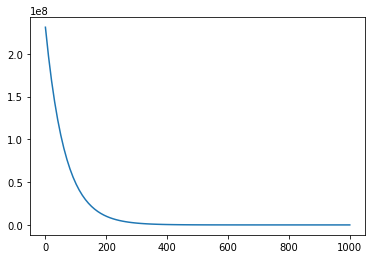

In [135]:
def dual_new_ub(theta):
    lam1, lam2, lam3, lam4 = theta[:m], theta[m:2*m], theta[2*m:2*m+n], theta[2*m+n:]
    z = np.exp((E @ (lam1 - lam2) + lam3 - lam4) / kx - 1)
    return (
        z @ kx
        + (1 - 1 / x_lb) @ lam1
        + (1 / x_ub - 1) @ lam2
        - lam3 @ z_ub
        + lam4 @ z_lb
    )


y = []
x = np.linspace(0, 1000, 100)
for lam2 in x:
    theta = np.asarray([1000, lam2, 0, 0, 0, 0])
    y.append(dual_new_ub(theta))
    
plt.plot(x, y)
plt.show()

In [218]:
y_min = np.inf
theta_min = None
draws = 1e7
thetas = np.random.uniform(-100, 0, size=(int(draws), 2*m + 2*n))

for theta in thetas:
#     theta[2:] = 0
#     theta[1] = 0
    y = dual_new_ub(theta)
    if y < y_min:
        theta_min = theta
        y_min = y

In [219]:
dual_new_ub(theta_min)

284.530783501036

In [220]:
theta_min

array([-6.85691134e+00, -8.36520414e-02, -2.71092755e+00, -1.25084088e+01,
       -4.05357987e-03, -4.37376335e+00])

In [221]:
y_min

284.530783501036

In [25]:
m, n = 3, 10

np.random.seed(1)
w = np.random.uniform(0, 1, size=m)
w /= np.sum(w)

a_range = (-0.0, 4.0)
b_range = (0.001, 0.01)
a = [np.random.uniform(*a_range, size=n) for _ in range(m)]
b = np.random.uniform(*b_range, size=n)
problem = OptimizationProblem(a, b, w)

# r = 0.1
# x = np.asarray([0.5, 0.5, 0.5])
c = 0
segment = problem.segments[0]
x_ub_c = 0.2
x_lb_c = 0.1


def inequality_1(q):
    return np.sum(q) - 1 + x_ub_c

def inequality_2(q):
    return 1 - np.sum(q) - x_lb_c

constr = [
    {"type": "ineq", "fun": inequality_1},
    {"type": "ineq", "fun": inequality_2},
]

opt = minimize(
    lambda q: -segment.revenue(q),
    np.zeros(n) + (x_ub_c + x_lb_c) / (2 * n),
    bounds=[(0, 1)] * n, 
    method="SLSQP",
    constraints=constr,
)

print(np.sum(segment.p_opt * segment.purchase_probabilities(segment.p_opt)))
print(-opt.fun)
print(opt.message)

712.0435818668125
518.2302536844724
Optimization terminated successfully.


In [26]:
1 - np.sum(opt.x)

0.19999999999998697

In [27]:
segment.x_opt

0.5110744840298456

In [138]:
opt

     fun: -1477.5271540696397
     jac: array([-1464.1320343 ,  -566.15242004, -1402.08448792, -1470.13262939,
       -1456.31904602,  -671.43203735, -1103.54161072, -1024.90971375,
       -1470.72068787,  -369.03744507,  -806.99034119,  -923.03044128,
       -1464.52592468,  -619.15496826,  -636.36912537, -1468.10058594,
       -1468.12200928, -1469.22360229,  -828.82832336, -1463.89309692])
 message: 'Positive directional derivative for linesearch'
    nfev: 2493
     nit: 109
    njev: 105
  status: 8
 success: False
       x: array([4.67888098e-01, 8.62550359e-06, 4.91943082e-05, 2.35071709e-04,
       1.26149888e-03, 8.99086562e-06, 1.08130756e-05, 1.02992036e-05,
       6.78696971e-03, 7.94848847e-06, 9.44668742e-06, 9.88575274e-06,
       1.53389409e-03, 8.80956293e-06, 8.86825903e-06, 3.80307466e-04,
       4.89003011e-03, 3.60067380e-04, 9.55205073e-06, 1.66082051e-02])

In [104]:
opt.x

array([2.86943688e-05, 4.22714793e-03, 1.20041169e-02, 3.17826984e-03,
       6.93165878e-02, 6.49360616e-04, 4.60323686e-01, 1.98034694e-05,
       5.85999071e-05, 3.94036583e-05, 4.36855292e-03, 5.78174078e-05,
       3.06262317e-03, 7.41223923e-05, 8.53519266e-04, 8.50628937e-02,
       7.80513296e-03, 4.67069292e-06, 1.46744913e-05, 3.67991434e-05])

In [3]:
m, n = 3, 100

w = np.random.uniform(0, 1, size=m)
w /= np.sum(w)

a_range = (-0.0, 5.0)
b_range = (0.001, 0.01)
a = [np.random.uniform(*a_range, size=n) for _ in range(m)]
b = np.random.uniform(*b_range, size=n)
problem = OptimizationProblem(a, b, w)
A, b = problem.A, problem.b

def qvi(pi, ai, bi, w, vi):
    u = ai - bi * pi  # (m, )
    exp_u = np.exp(u)
    return - np.sum(pi * w * exp_u / (1 + vi + exp_u))
    


v = np.zeros((m, 1))
p_lb = np.copy(problem.p_lb)

for _ in range(10):
    
    for i in range(n):
        pi = p_lb[i]
        ai = problem.A[:, i]
        bi = problem.b[i]
        w = problem.w
        Ai = np.exp(A - b * p_lb)
        Ai[:, i] = 0 
        vi = np.sum(Ai, axis=1)
        args = (ai, bi, w, vi)
        opt = minimize(qvi, pi, args=args)
        assert opt.success
        p_lb[i] = opt.x

    
print(problem.x_lb)

for segment in problem.segments:
    print(segment.no_purchase_probability(p_lb))

# for old, new in zip(problem.p_lb, p_lb):
#     print(old, new)

[0.00084775 0.00088435 0.00109621]
0.0008674757486851759
0.0008960558678077213
0.0011241601415711289


[3.71364678e-05 5.46291048e-05]
4.394849252642441e-05
6.879936271464437e-05


In [47]:
ai = problem.A[:, 0]

array([6.80632342, 5.63471697])

In [44]:
problem.p_lb

array([438.07376707, 188.89374566, 140.02956876, 149.92147247,
       230.8399059 , 101.04087674, 127.79242457, 101.38554442,
       250.59482942, 111.98999199, 205.33567477, 117.72454263,
       570.15232684, 163.25074289, 129.42886411, 527.88651006,
       361.54633844, 269.58142274, 256.38220606, 361.48184658,
       150.56652004, 133.01312772, 394.78808626, 130.55837158,
       357.50968908, 120.36485224, 112.74727259, 223.9994375 ,
       100.85379914, 112.1420848 , 110.51282437, 100.16993924,
       341.48058608, 212.08760726, 146.79151067, 123.40330529,
       168.00706404, 362.76495797, 142.76598541, 159.22547853,
       105.03921017, 139.32423076, 146.75006975, 204.52377835,
       101.19718361, 247.6557068 , 448.38691497, 240.66771615,
       400.70223392, 181.8771771 ])

In [40]:
np.expand_dims(problem.w, axis=-1)

(2, 1)

In [11]:
np.sum(problem.A, axis=0).shape

(50,)

In [14]:
A, b = problem.A, problem.b


(2, 50)

In [17]:
from bnb.fml_solver import FMLSolver
from bnb.problem import OptimizationProblem
import numpy as np
from scipy.optimize import minimize


for _ in range(10000):
    m, n = 2, 30

    w = np.random.uniform(0, 1, size=m)
    w /= np.sum(w)

    a_range = (-0.0, 4.0)
    b_range = (0.0001, 0.001)
    a = [np.random.uniform(*a_range, size=n) for _ in range(m)]
    b = np.random.uniform(*b_range, size=n)
    problem = OptimizationProblem(a, b, w)
    solver = FMLSolver(problem, epsilon=0.0001)
    solver.solve()


    cubes = [cube for cube in solver.cubes if cube.branch]
    # print(cubes[0].center)
    # print(np.max([np.max(cube.center) for cube in cubes]))
    # print(problem.x_lb)
    # print(problem.x_ub)
    # print(problem.w * problem.x_ub)
    # assert all(cubes[0].center > np.min(problem.w * problem.x_ub))
    
    xs = []
    for i, center in enumerate(cubes[0].center):
        x_opt = problem.segments[i].x_opt
        wi = problem.w[i]
        xs.append(wi * x_opt)
    assert all(cubes[0].center > np.min(xs))
        

In [8]:
center, wi * x_opt

(0.26526747186590954, 0.26620551545222737)

In [2]:
problem.segments[0].x_opt

0.26197504179746234

In [77]:
problem.x_lb

array([2.57767377e-05, 2.94385843e-05])

In [81]:
10 ** -5

1e-05

In [16]:
cube = solver.cubes[0]

0.2678123795667066

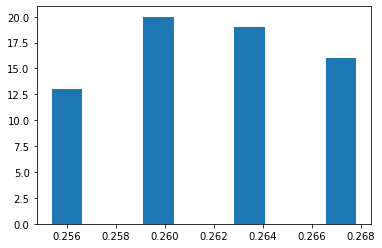

In [36]:
from matplotlib import pyplot as plt

plt.hist([)
plt.show()

In [5]:
problem.x_lb

array([0.00087508])

In [6]:
problem.x_ub

array([0.22555859])